In [85]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# stats
from statsmodels.api import tsa # time series analysis
import statsmodels.api as sm

# JAX
import jax.numpy as jnp
from jax import random, jit
import time

# RELOADING MODULES
import importlib

# UTILS DIRECTORY
import sys
import os
collocation2_path = os.path.abspath(os.path.join('..', '00_utils'))

if collocation2_path not in sys.path:
    sys.path.append(collocation2_path)

# from collocation import compute_weights, lagrange_derivative

import neural_net_jax
importlib.reload(neural_net_jax)
NeuralODE_JAX = neural_net_jax.NeuralODE

,settlement_date,temperature,conditions,precip,cloudcover,humidity,windspeed,nd,pump_storage_pumping,is_holiday
0,2010-01-01 00:00:00,2.5,Partially cloudy,0.0,43.6,75.52,16.2,36566.5,264.5,1.0
1,2010-01-01 01:00:00,0.6,Partially cloudy,0.0,36.1,86.19,14.0,35852.5,289.5,1.0
2,2010-01-01 02:00:00,0.8,Partially cloudy,0.0,48.8,85.14,16.7,34189.5,461.0,1.0
3,2010-01-01 03:00:00,0.7,Partially cloudy,0.0,68.1,83.74,13.9,32453.0,1334.0,1.0
4,2010-01-01 04:00:00,0.4,Partially cloudy,0.0,34.5,83.66,12.2,30450.5,1387.5,1.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9048 entries, 0 to 9047
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   settlement_date       9048 non-null   object 
 1   temperature           9048 non-null   float64
 2   conditions            9048 non-null   object 
 3   precip                9048 non-null   float64
 4   cloudcover            9048 non-null   float64
 5   humidity              9048 non-null   float64
 6   windspeed             9048 non-null   float64
 7   nd                    9048 non-null   float64
 8   pump_storage_pumping  9048 non-null   float64
 9   is_holiday            9048 non-null   float64
dtypes: float64(8), object(2)
memory usage: 707.0+ KB


None

settlement_date         0
temperature             0
conditions              0
precip                  0
cloudcover              0
humidity                0
windspeed               0
nd                      0
pump_storage_pumping    0
is_holiday              0
dtype: int64

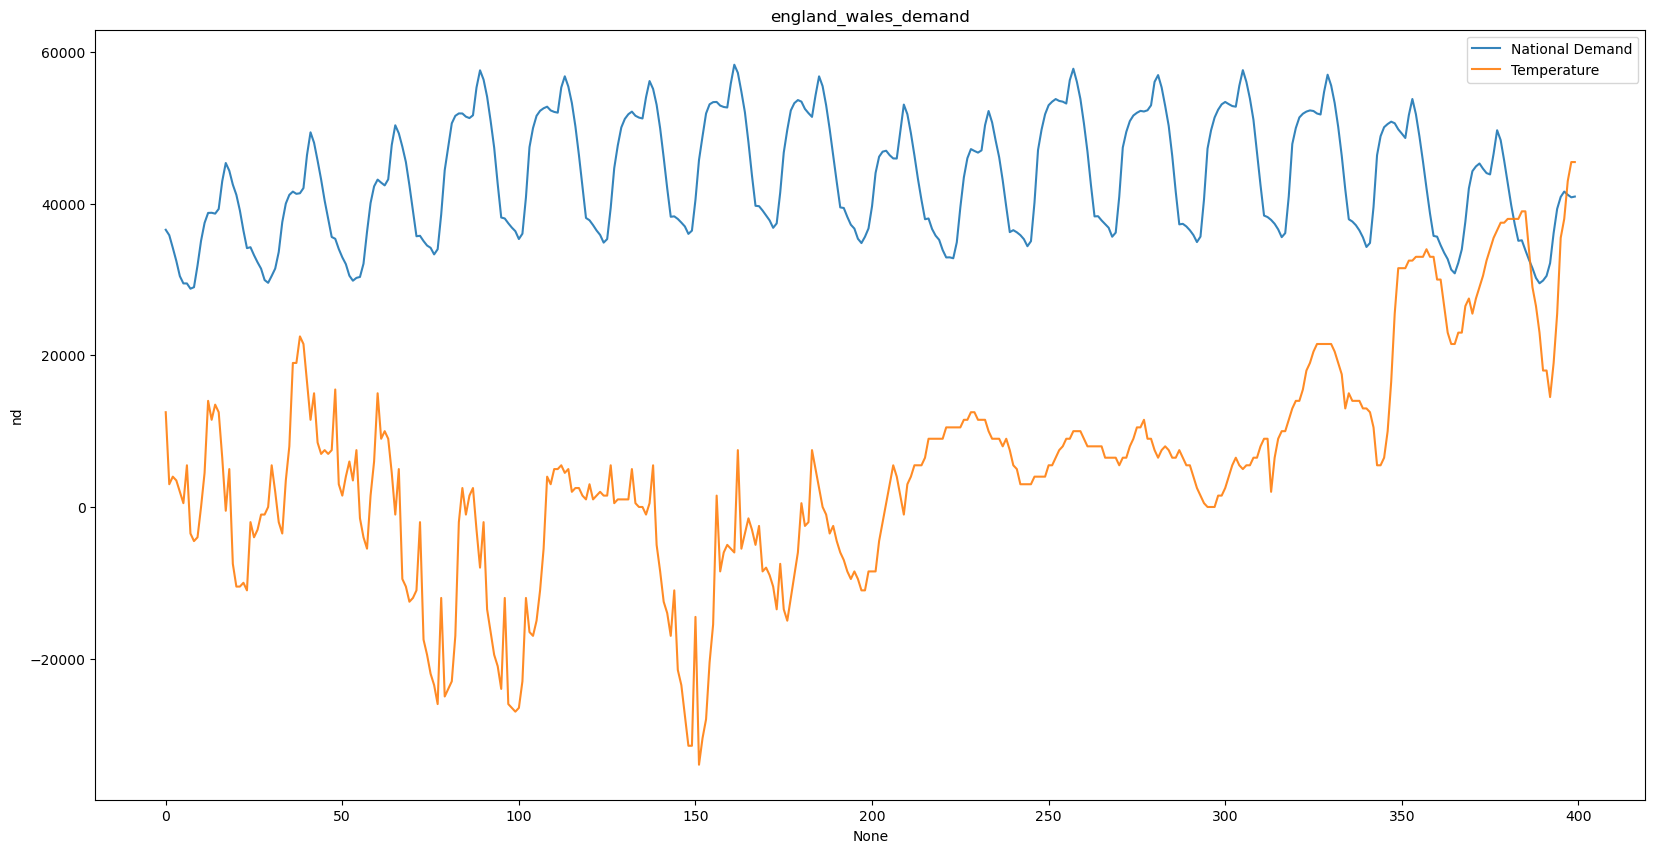

In [86]:
data = pd.read_csv('df_train.csv')

data = data[data.settlement_date >= '2010-01-01']
data = data[data.settlement_date < '2011-01-01']
data.reset_index(drop=True, inplace=True)

display(data.head())
display(data.info())
display(data.isna().sum())

end = 400
data_subsample = data[:end]
data_subsample.shape

plt.figure(figsize=(20, 10))
sns.lineplot(x=data_subsample.index, y="nd", data=data_subsample, label="National Demand", alpha = 0.9) 
sns.lineplot(x=data_subsample.index, y=(data_subsample.temperature)*5000, data=data_subsample, label="Temperature", alpha = 0.9) 
plt.title("england_wales_demand")
plt.grid(False)
plt.legend()
plt.plot();

## Split Data

In [87]:
split = 200

data_subsample.loc[:,'hour'] = pd.to_datetime(data_subsample['settlement_date']).dt.hour

X = data_subsample.drop('nd', axis=1) 
y = data_subsample['nd'] 
X = X[['temperature', 'hour']]

X_train = X[:split]
y_train = y[:split]

X_test = X[split:]
y_test = y[split:]

/var/folders/2v/gfm3z1tn5fj8zss_r9hrgnv80000gn/T/ipykernel_27268/679842150.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_subsample.loc[:,'hour'] = pd.to_datetime(data_subsample['settlement_date']).dt.hour


## Scale data

In [88]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled)
X_train_scaled.columns = X_train.columns
X_test_scaled = pd.DataFrame(X_test_scaled)
X_test_scaled.columns = X_test.columns

y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler.transform(y_test.values.reshape(-1, 1))

In [89]:
t = jnp.linspace(0., 1., end)

t_train = t[:split]
t_test = t[split:]

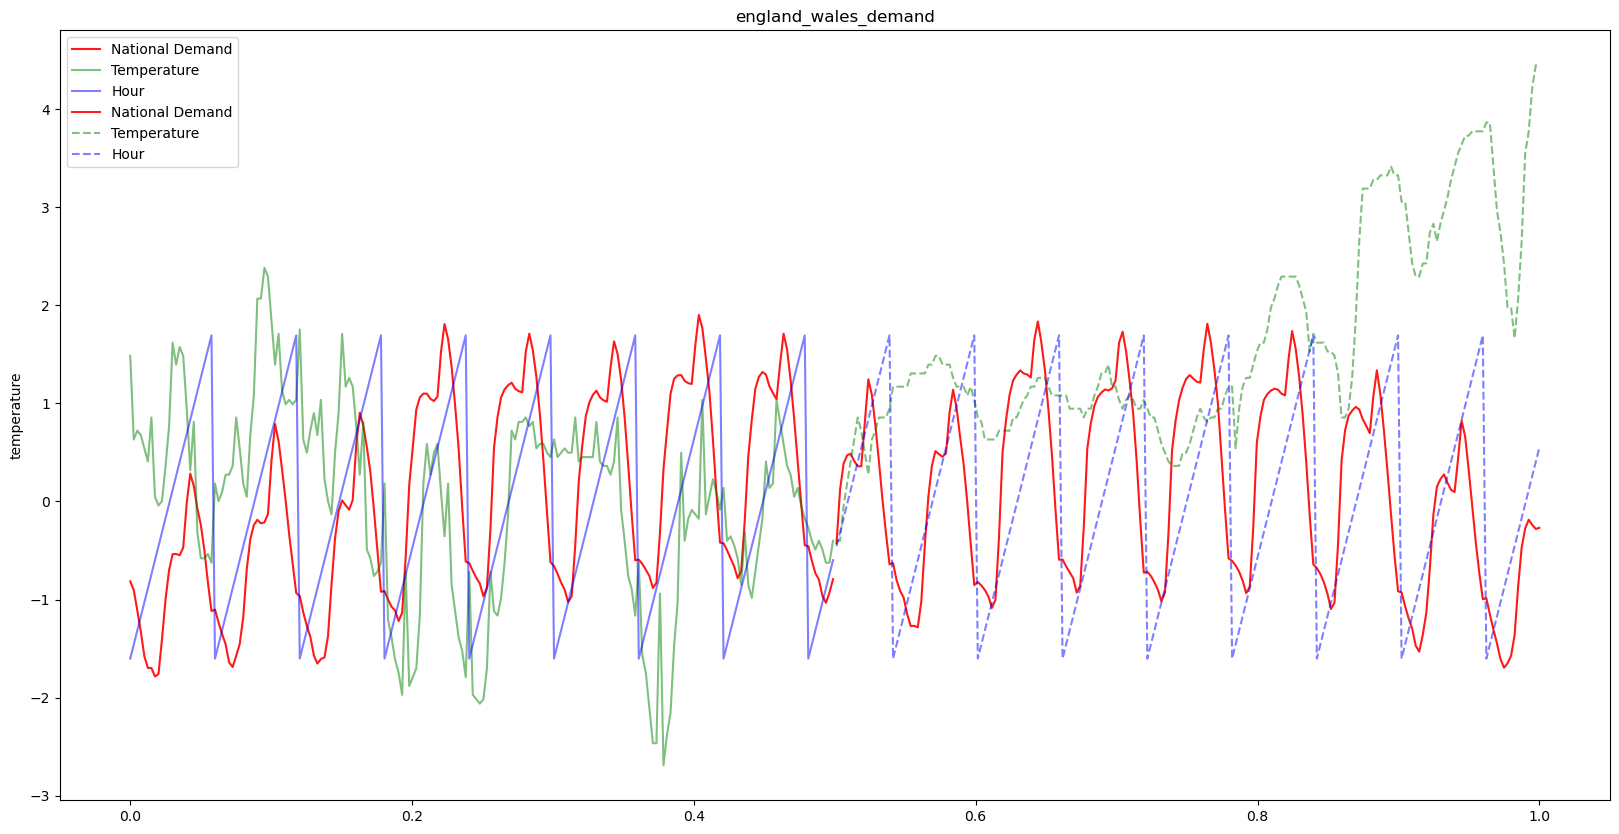

In [90]:
plt.figure(figsize=(20, 10))
sns.lineplot(x=t_train, y=np.squeeze(y_train_scaled.T), label="National Demand", alpha = 0.9, color='red') 
sns.lineplot(x=t_train, y=X_train_scaled['temperature'], label="Temperature", alpha = 0.5, color='green') 
sns.lineplot(x=t_train, y=X_train_scaled['hour'], label="Hour", alpha = 0.5, color='blue') 

sns.lineplot(x=t_test, y=np.squeeze(y_test_scaled.T), label="National Demand", alpha = 0.9, color='red') 
sns.lineplot(x=t_test, y=X_test_scaled['temperature'], label="Temperature", alpha = 0.5, color='green', ls = '--') 
sns.lineplot(x=t_test, y=X_test_scaled['hour'], label="Hour", alpha = 0.5, color='blue', ls = '--') 
plt.title("england_wales_demand")
plt.grid(False)
plt.legend()
plt.plot();

## Train on Auxiliary Variables

In [91]:
print(t_train.shape)
print(y_train_scaled.shape)
print(X_train_scaled.shape)

(200,)
(200, 1)
(200, 2)


In [92]:
def create_delayed_embeddings(x, tau, m):
    n = x.shape[0]  
    
    embeddings = []  
    
    for i in range(n - m * tau):
        if x.ndim == 2:
             embedding = jnp.array([x[i + j * tau, 0] for j in range(m)])  
        elif x.ndim == 1:
            embedding = jnp.array([x[i + j * tau] for j in range(m)])     
        else:
            raise ValueError("Input array x must be either 1D or 2D.")
        embeddings.append(embedding)
    
    return jnp.vstack(embeddings)


tau = 1
m = 3
offset = tau*m
embeddings_train = create_delayed_embeddings(y_train_scaled, tau, m)

In [93]:
offset = tau*m

#---------------------------PREPARE THE EXTRA ARGUMENTS--------------------------#
X_train_scaled_jnp = jnp.array(X_train_scaled[offset:])
X_train_scaled_embed = jnp.concatenate([X_train_scaled_jnp, embeddings_train], axis = 1)

ts = t_train[offset:]
ys = jnp.array(y_train_scaled)[offset:]
y0 = y_train_scaled[offset]
extra_args = (jnp.array(X_train_scaled_embed), ts)

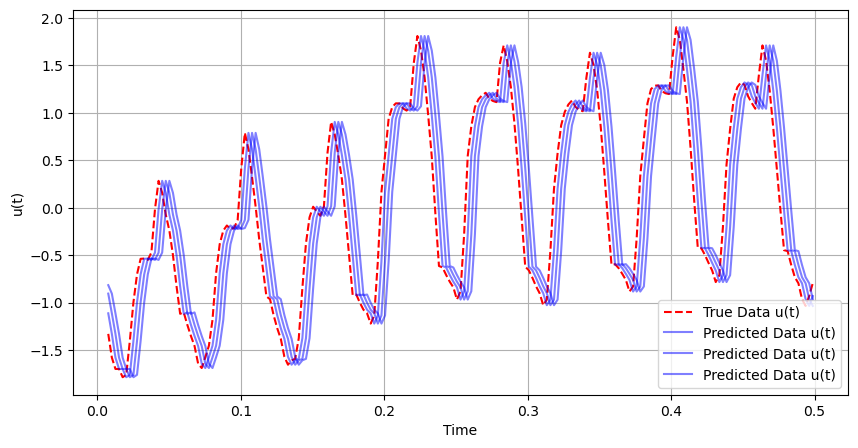

In [94]:
#---------------------------PLOTTING RESULTS--------------------------#
plt.figure(figsize=(10, 5))

plt.plot(ts, ys, 'r--', label='True Data u(t)')  
plt.plot(ts, embeddings_train, 'b', label='Predicted Data u(t)', alpha = 0.5) 

plt.xlabel('Time')
plt.ylabel('u(t)')
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()

In [95]:
import neural_net_jax_diffrax
importlib.reload(neural_net_jax_diffrax)
NeuralODE_JAX = neural_net_jax_diffrax.NeuralODE

layer_widths = [6, 64, 64, 1]
learning_rate = 1e-3
rng = random.PRNGKey(42)

node_model = NeuralODE_JAX(layer_widths, time_invariant=True)

state = node_model.create_train_state(rng, learning_rate)

ts = t_train[offset:]
ys = jnp.array(y_train_scaled)[offset:]
y0 = y_train_scaled[offset]
extra_args = (jnp.array(X_train_scaled_embed), t_train[offset:])

state = node_model.train(state, ts 
                         , ys, y0
                         , num_epochs = 50000
                         , extra_args=extra_args
                         )

Epoch 100, Loss: 146.53787231445312
Epoch 200, Loss: 137.90309143066406
Epoch 300, Loss: 134.481201171875
Epoch 400, Loss: 131.47689819335938
Epoch 500, Loss: 125.4002456665039
Epoch 600, Loss: 126.42298126220703
Epoch 700, Loss: 121.97320556640625
Epoch 800, Loss: 118.24501037597656
Epoch 900, Loss: 111.34785461425781
Epoch 1000, Loss: 106.26853942871094
Epoch 1100, Loss: 100.695556640625
Epoch 1200, Loss: 96.66886138916016
Epoch 1300, Loss: 88.13626098632812
Epoch 1400, Loss: 85.89903259277344
Epoch 1500, Loss: 79.1123046875
Epoch 1600, Loss: 75.32867431640625
Epoch 1700, Loss: 73.36491394042969
Epoch 1800, Loss: 68.92090606689453
Epoch 1900, Loss: 67.18119812011719
Epoch 2000, Loss: 62.54526138305664
Epoch 2100, Loss: 59.900333404541016
Epoch 2200, Loss: 55.953792572021484
Epoch 2300, Loss: 57.4478645324707
Epoch 2400, Loss: 51.151527404785156
Epoch 2500, Loss: 45.68118667602539
Epoch 2600, Loss: 51.72893142700195
Epoch 2700, Loss: 41.092952728271484
Epoch 2800, Loss: 37.98003387451

### Predictions

In [96]:
import neural_net_jax_diffrax
importlib.reload(neural_net_jax_diffrax)
NeuralODE_JAX = neural_net_jax_diffrax.NeuralODE

# reload
node_model = NeuralODE_JAX(layer_widths, time_invariant=True)

#  def neural_ode(self, params, y0, t, state, extra_args=None): 
y_train_pred = node_model.neural_ode(state.params, y0, ts, state, extra_args)

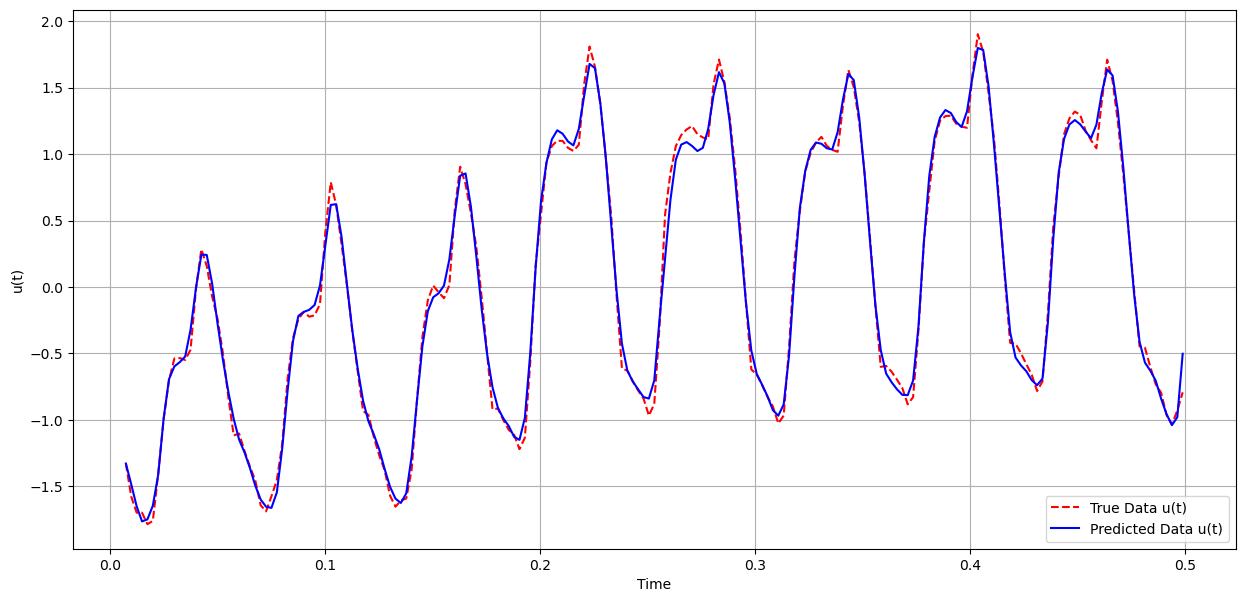

In [97]:
#---------------------------PLOTTING RESULTS--------------------------#
plt.figure(figsize=(15, 7))

plt.plot(ts, ys, 'r--', label='True Data u(t)')  
plt.plot(ts, y_train_pred, 'b', label='Predicted Data u(t)') 

plt.xlabel('Time')
plt.ylabel('u(t)')
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()

In [98]:
# create a vector to store all of embeddings
y_full_scaled = jnp.concatenate([y_train_scaled, y_test_scaled])

# ensure the test points are not leaked into the training set
y_full_scaled = np.array(y_full_scaled)
for i in range(split, len(y_full_scaled)):
    y_full_scaled[i] = np.nan

y_full_scaled = y_full_scaled

In [99]:
def fetch_embeddings(y, tau, m, index):
    # use slicing to get the embeddingsa
    return jnp.squeeze(y[index - m * tau : index : tau].T)

fetch_embeddings(y_full_scaled, tau, m, 200)

Array([-1.033712 , -0.9297511, -0.7924054], dtype=float32)

In [100]:
importlib.reload(neural_net_jax_diffrax)
NeuralODE_JAX = neural_net_jax_diffrax.NeuralODE

# reload the model
node_model = NeuralODE_JAX(layer_widths, time_invariant=True)

# rrepare an array to append to 
X_full_scaled_embed = jnp.array(X_train_scaled_embed)

# the last known value is: (split - 1) 
init_value = jnp.array([y_train_pred[-1][0]])

@jit
def process_current_value(state, init_value, t_predict, X_full_scaled_embed, t_full):
    extra_args = (X_full_scaled_embed, t_full)
    return node_model.neural_ode(state.params, init_value, t_predict, state, extra_args)[1]

# loop over each test point, starting at the split point
for current_index in range(split, len(y_full_scaled)):
    if current_index % 10 == 0:
        print(f'Processing index: {current_index}')
    # fetch the embedding for the current index
    embeddings_row = fetch_embeddings(y_full_scaled, tau, m, current_index)

    if np.isnan(embeddings_row).any():
        print('There are missing values in the embeddings')

    # fetch the X values for the current index
    X_test_scaled_row = jnp.array(X_test_scaled.iloc[current_index - split])

    # append 1D rows
    current_row = jnp.append(X_test_scaled_row, embeddings_row)
    X_full_scaled_embed = jnp.vstack([X_full_scaled_embed, current_row])

    # define time arrays
    t_full = jnp.array(t[offset:current_index + 1])
    t_predict = jnp.array(t[current_index - 1:current_index + 1])

    # call the JIT-compiled function to process the current value
    current_value = process_current_value(state, init_value, t_predict, X_full_scaled_embed, t_full)

    # update the initial value for the next iteration
    init_value = current_value

    # save the current value to the noisy embeddings
    y_full_scaled[current_index] = current_value

Processing index: 200
Processing index: 210
Processing index: 220
Processing index: 230
Processing index: 240
Processing index: 250


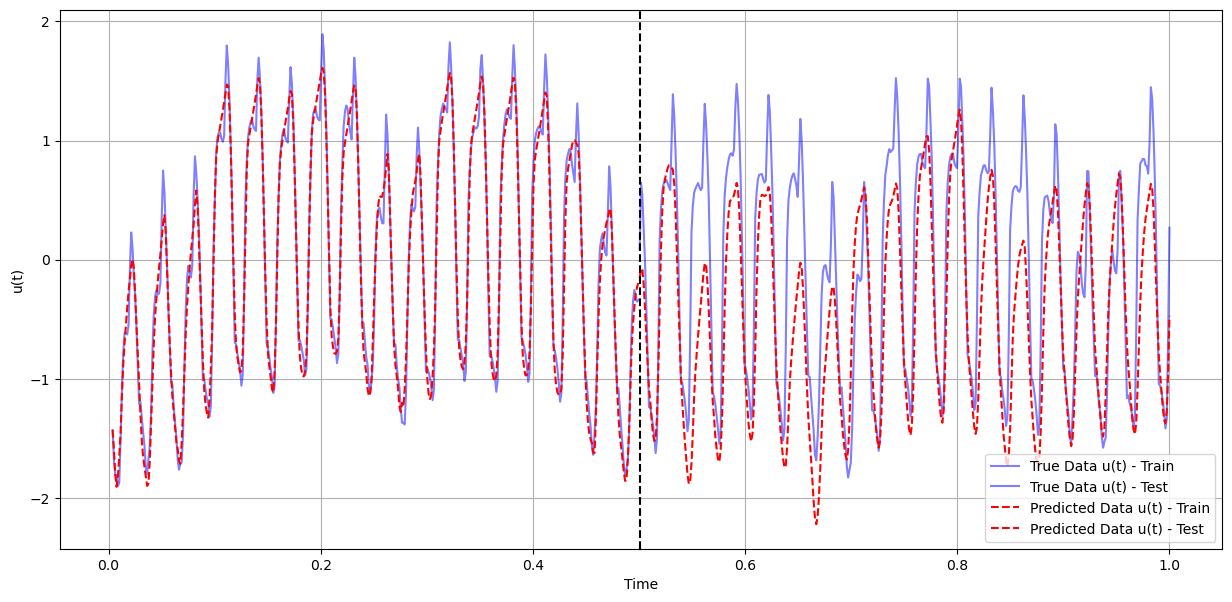

In [81]:
#---------------------------PLOTTING RESULTS--------------------------#
plt.figure(figsize=(15, 7))

plt.plot(ts, ys, 'b', label='True Data u(t) - Train', alpha = 0.5)  
plt.plot(t_test, y_test_scaled, 'b', label='True Data u(t) - Test', alpha = 0.5) 
plt.plot(ts, y_train_pred, 'r--', label='Predicted Data u(t) - Train') 
plt.plot(t[split:], y_full_scaled[split:], 'r--', label='Predicted Data u(t) - Test') 

plt.axvline(x=t[split], color='black', linestyle='--')

plt.xlabel('Time')
plt.ylabel('u(t)')
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()